### Study initial dataset

In [1]:
import os
from pathlib import Path
from pymatgen.io.cif import CifWriter
from mp_api.client import MPRester
import pandas as pd
import numpy as np
from matplotlib_venn import venn2

# conda env config vars set MP_API_KEY=your_key
api_key = os.environ.get("MP_API_KEY")

In [2]:
# read ids
ids = pd.read_csv("./data/material-data/mp-ids-46744.csv")
ids = [list(ids)[0]] + list(ids.iloc[:, 0])
print(len(ids))

46744


In [3]:
# my venn diagram for two sets
def venn(**kvarg):
    subsets = []
    set_labels = []
    for k, v in kvarg.items():
        subsets.append(set(v))
        set_labels.append(k)
    venn2(subsets=subsets, set_labels=set_labels)


# get duplicates set of duplicates
def get_duplicates_list(a: list):
    h = dict()
    for x in a:
        h.setdefault(x, 0)
        h[x] += 1
    repeated = list()
    for k, v in h.items():
        if v > 1:
            repeated += [k for i in range(1, v)]
    return repeated


def get_duplicates_set(a: list):
    return set(get_duplicates_list(a))

In [4]:
# with MPRester(api_key) as mpr:
#     naive_docs = mpr.materials.search(material_ids=ids, fields=['material_id'])
# ValueError: List of material/molecule IDs provided is too long. Consider removing the ID filter to automatically pull data for all IDs and filter locally.
# fix via chunk loading with const:
# 10000

from emmet.core.vasp.material import MaterialsDoc


def chunked_load_ids(kind_of_ids: str, **kwargs) -> list[MaterialsDoc]:
    """kwargs[kind_of_ids] is divided into chunks"""
    if kind_of_ids not in kwargs:
        return []
    chunk_size = 10000
    docs = []
    with MPRester(api_key) as mpr:
        ids = kwargs[kind_of_ids]
        kwargs.pop(kind_of_ids)
        for k in range(0, len(ids), chunk_size):
            chunk = [
                doc
                for doc in mpr.materials.search(
                    **dict([(kind_of_ids, ids[k : k + chunk_size])]), **kwargs
                )
            ]
            docs += chunk
    return docs

#### Naive approach

In [55]:
docs_naive = chunked_load_ids("material_ids", material_ids=ids, fields=["material_id"])
depr_docs_naive = chunked_load_ids(
    "material_ids", material_ids=ids, fields=["material_id"], deprecated=True
)

In [ ]:
material_ids_naive = [str(doc.material_id) for doc in docs_naive]
material_ids_duplicates_naive = get_duplicates_set(material_ids_naive)

depr_material_ids_naive = [str(doc.material_id) for doc in depr_docs_naive]
depr_material_ids_duplicates_naive = get_duplicates_set(depr_material_ids_naive)

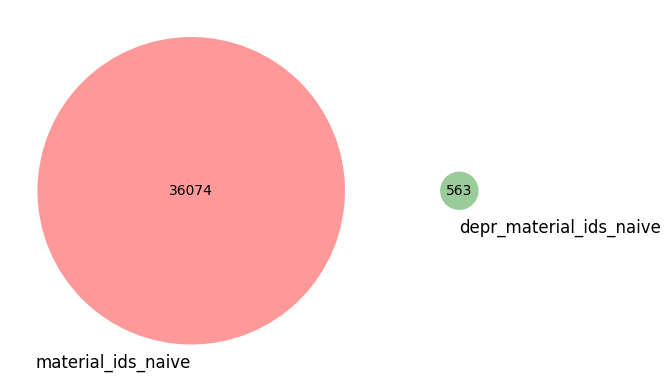

In [ ]:
venn(
    material_ids_naive=material_ids_naive,
    depr_material_ids_naive=depr_material_ids_naive,
)

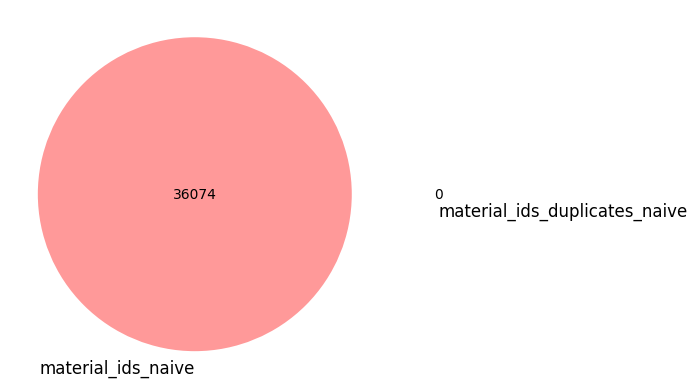

In [ ]:
venn(
    material_ids_naive=material_ids_naive,
    material_ids_duplicates_naive=material_ids_duplicates_naive,
)

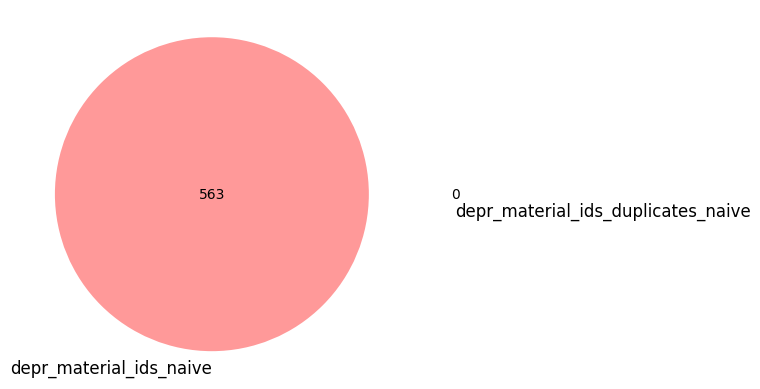

In [ ]:
venn(
    depr_material_ids_naive=depr_material_ids_naive,
    depr_material_ids_duplicates_naive=depr_material_ids_duplicates_naive,
)

#### Different approach

Taking into consideration that listed ids are task ids.

In [ ]:
docs = chunked_load_ids("task_ids", task_ids=ids, fields=["material_id"])
depr_docs = chunked_load_ids(
    "task_ids", task_ids=ids, fields=["material_id"], deprecated=True
)

/home/nodoteve/apps/pythom/miniconda/envs/cgcnn2/lib/python3.11/site-packages/mp_api/client/mprester.py:227: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving MaterialsDoc documents:   0%|          | 0/9872 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9868 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9870 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9885 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/6668 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/128 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/132 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/130 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/115 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/76 [00:00<?, ?it/s]

In [ ]:
material_ids = [str(d.material_id) for d in docs]
material_ids_duplicates = get_duplicates_set(material_ids)

depr_material_ids = [str(d.material_id) for d in depr_docs]
depr_material_ids_duplicates = get_duplicates_set(depr_material_ids)

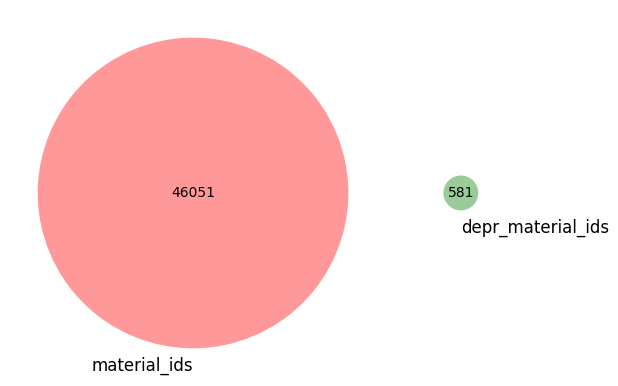

In [ ]:
venn(material_ids=material_ids, depr_material_ids=depr_material_ids)

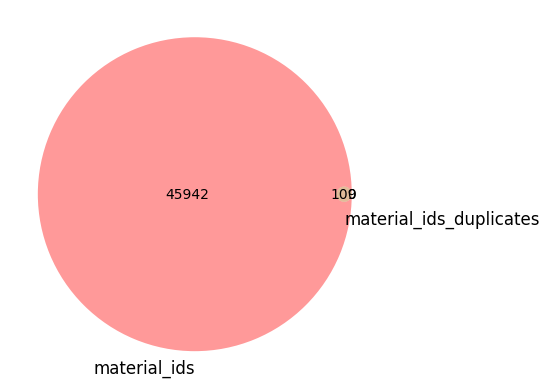

In [ ]:
venn(material_ids=material_ids, material_ids_duplicates=material_ids_duplicates)

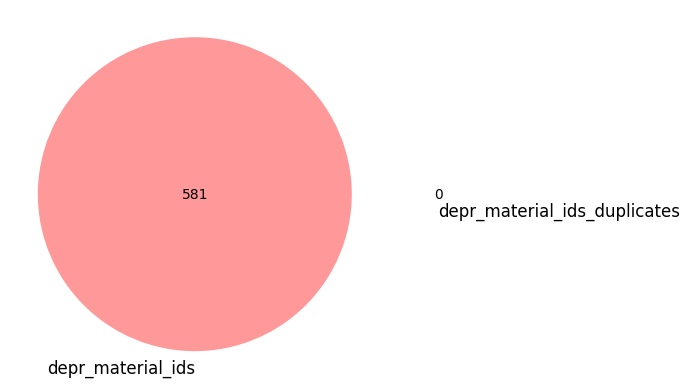

In [ ]:
venn(
    depr_material_ids=depr_material_ids,
    depr_material_ids_duplicates=depr_material_ids_duplicates,
)

Knowing the complete set of material_ids it is possible to create a map between task_ids and material_ids

In [ ]:
all_mids = list(set(material_ids).union(set(depr_material_ids)))
docs_for_t2m = chunked_load_ids(
    "material_ids", material_ids=all_mids, fields=["material_id", "task_ids"]
)
depr_docs_for_t2m = chunked_load_ids(
    "material_ids",
    material_ids=all_mids,
    fields=["material_id", "task_ids"],
    deprecated=True,
)

Retrieving MaterialsDoc documents:   0%|          | 0/9880 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9881 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9868 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/9882 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/6540 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/120 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/119 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/132 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/118 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
mids = [str(d.material_id) for d in docs_for_t2m]
depr_mids = [str(d.material_id) for d in depr_docs_for_t2m]

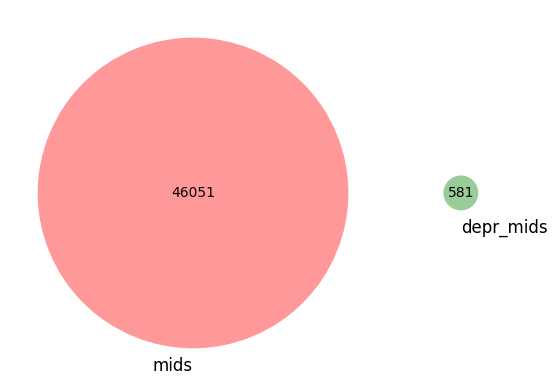

In [ ]:
venn(mids=mids, depr_mids=depr_mids)
# No venn intersection => mids are unique

In [ ]:
mt_ids = [(str(d.material_id), [str(x) for x in d.task_ids]) for d in docs_for_t2m]
depr_mt_ids = [
    (str(d.material_id), [str(x) for x in d.task_ids]) for d in depr_docs_for_t2m
]

# keep only task_ids from (initial) ids.
sids = set(ids)
redused_mt_ids = [(m, [x for x in t if x in sids]) for m, t in mt_ids]
redused_depr_mt_ids = [(m, [x for x in t if x in sids]) for m, t in depr_mt_ids]

# flatten
all_tids = []
for m, t in redused_mt_ids:
    all_tids += t
for m, t in redused_depr_mt_ids:
    all_tids += t
print(len(get_duplicates_set(all_tids)))

0


Correspondence between tids and mids strictly obeys the law that there is only one mid for the given tid.

In [ ]:
# create map task_id -> material_id
t2m = dict()
for m, t in mt_ids:
    for x in t:
        t2m[x] = m
for m, t in depr_mt_ids:
    for x in t:
        t2m[x] = m
found = [x for x in ids if x in t2m]
not_found = [x for x in ids if x not in t2m]

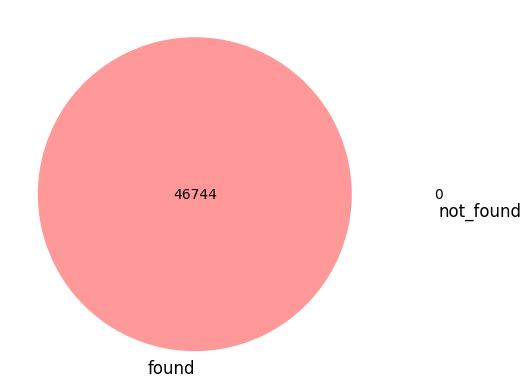

In [ ]:
# compare with (initial) ids
venn(found=found, not_found=not_found)

In [ ]:
# set theoretical image of ids after t2m
img = [t2m[x] for x in ids]

46632 + 112 = 46744


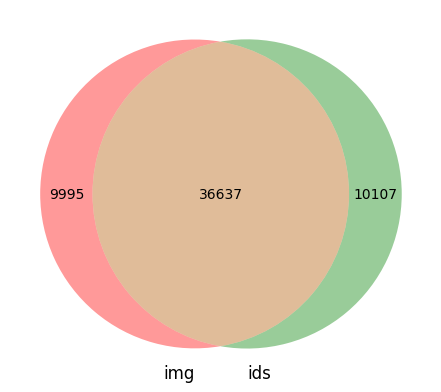

In [ ]:
print(len(set(img)), "+", len(get_duplicates_list(img)), "=", len(ids))
venn(img=img, ids=ids)
# => Actual number of duplicates (data leak) in article implementation could be around the value of get_duplicates_list(img))
# or 100 ids out of 46744 (~0.2%)
# (~800 and 1.8% in previous version of db)

### Dataset creation
Creating datasets based on material project ids. Then checking the difference in training results.

#### Load data

##### From Materials Project

In [5]:
# dataset saving paths
basedir = "./data/root/data/"
t2m_file = "./data/root/data/t2m.json"


def save_to_bin(data: dict, output_file):
    import ormsgpack

    with open(output_file, "wb") as f:
        f.write(ormsgpack.packb(data, option=ormsgpack.OPT_SERIALIZE_NUMPY))


def load_from_bin(file):
    with open(file, "rb") as f:
        import ormsgpack

        return ormsgpack.unpackb(f.read())


def save_to_json(data: dict, output_file):
    import orjson

    with open(output_file, "wb") as f:
        f.write(orjson.dumps(data, option=orjson.OPT_SERIALIZE_NUMPY))


def load_from_json(file):
    with open(file, "rb") as f:
        import orjson

        return orjson.loads(f.read())

In [6]:
def chunked_load_data(kind_of_ids: str, **kwargs) -> list[MaterialsDoc]:
    """kwargs[kind_of_ids] is divided into chunks
    differs from chunked_load_ids():
        mpr.materials.search
        ->
        mpr.materials.summary.search"""
    if kind_of_ids not in kwargs:
        return []
    chunk_size = 10000
    docs = []
    with MPRester(api_key) as mpr:
        ids = kwargs[kind_of_ids]
        kwargs.pop(kind_of_ids)
        for k in range(0, len(ids), chunk_size):
            chunk = [
                doc
                for doc in mpr.materials.summary.search(
                    **dict([(kind_of_ids, ids[k : k + chunk_size])]), **kwargs
                )
            ]
            docs += chunk
    return docs

In [7]:
from datetime import date

# downloading functionality
fields = [
    "energy_per_atom",
    "formation_energy_per_atom",
    "band_gap",
    "efermi",
    "shear_modulus",  # "k_voigt", "k_reuss", "k_vrh", see https://docs.materialsproject.org/methodology/materials-methodology/elasticity/
    "bulk_modulus",  # "g_voigt","g_reuss", "g_vrh"
    "homogeneous_poisson",
]


def download_by_material_ids(mids) -> list[MaterialsDoc]:
    docs = chunked_load_data(
        "material_ids",
        material_ids=mids,
        fields=fields + ["structure", "material_id"],
    )
    depr_docs = chunked_load_data(
        "material_ids",
        material_ids=mids,
        fields=fields + ["structure", "material_id"],
        deprecated=True,
    )
    all_docs = depr_docs + docs
    return all_docs


def save_docs_as_json(docs: list[MaterialsDoc], dataset_dir: str):
    props = dict()
    cifs = dict()
    for doc in docs:
        mid = str(doc.material_id)
        # structures
        cifs[mid] = doc.structure.as_dict()

        # properties
        dump = doc.model_dump(include=fields)

        # translate shear_modulus and bulk_modulus to k_ and g_ in case they exist
        # example:
        #   dump["shear_modulus"]["vrh"] -> dump["k_vrh"]
        modulus_types = ["voigt", "reuss", "vrh"]
        key_map = {"shear_modulus": "k_", "bulk_modulus": "g_"}
        for k, v in key_map.items():
            if k in dump:
                if dump[k] is not None:
                    for t in modulus_types:
                        dump[v + t] = dump[k][t]
                        dump[k].pop(t)
                dump.pop(k)
        # training of these properties is performed in log scale
        for moduli in ["k_voigt", "k_reuss", "k_vrh", "g_voigt", "g_reuss", "g_vrh"]:
            if moduli in dump:
                dump[moduli] = np.log(dump[moduli])
        props[mid] = dump

    try:
        os.mkdir(dataset_dir)
    except:
        pass
    save_to_json(cifs, dataset_dir + "cifs.json")
    save_to_json(props, dataset_dir + "props.json")
    return dataset_dir

Download might take some time

In [8]:
# create dataset based on material ids from original paper
dataset_original_path = basedir + "dataset_original_" + date.today().isoformat() + "/"


# docs = []
def create_original():
    img = [t2m[x] for x in ids]
    docs = download_by_material_ids(mids=img)
    save_docs_as_json(docs, dataset_original_path)
    return [str(doc.material_id) for doc in docs]


# ~ 7 min

In [9]:
# ids1 = create_original()
# df1 = pd.DataFrame(load_from_json(dataset_original_path + "props.json")).transpose()
# print(df1.describe())

In [10]:
# create dataset from all materials available at Materials Project currently
dataset_full_path = basedir + "dataset_full_" + date.today().isoformat() + "/"


def create_full():
    def download_full_mpdb_undeprecated():
        with MPRester(api_key) as mpr:
            docs = [
                d
                for d in mpr.materials.summary.search(
                    fields=fields + ["structure", "material_id"],
                )
            ]
            return docs

    docs = download_full_mpdb_undeprecated()
    save_docs_as_json(docs, dataset_full_path)
    return [str(doc.material_id) for doc in docs]


# ~ 15 min

In [11]:
# ids2 = create_full()

In [12]:
# create delta dataset as a set difference of previous two
dataset_delta_path = basedir + "dataset_delta/"


def create_delta(ids1, ids2, dataset_full_path):
    ids_delta = set(ids2).difference(set(ids1))
    props_full = load_from_json(dataset_full_path + "props.json")
    props_delta = dict()
    for k, v in props_full.items():
        if k in ids_delta:
            props_delta[k] = v
    cifs_full = load_from_json(dataset_full_path + "cifs.json")
    cifs_delta = dict()
    for k, v in cifs_full.items():
        if k in ids_delta:
            cifs_delta[k] = v
    try:
        os.mkdir(dataset_delta_path)
    except:
        pass
    save_to_json(cifs_delta, dataset_delta_path + "cifs.json")
    save_to_json(props_delta, dataset_delta_path + "props.json")

In [13]:
# some thermodynamic properties of Materials Project significantly changed recently due to migration from GGA/GGA+U to r2SCAN
dataset_original_before_r2scan_path = basedir + "dataset_original_before_r2scan/"
dataset_full_before_r2scan_path = (
    basedir + "dataset_full_before_r2scan/"
)  # does not contain shear/bulk modulus

dataset_original_path = basedir + "dataset_original_2024-04-25/"
dataset_full_path = basedir + "dataset_full_2024-04-25/"
dataset_delta_path = basedir + "dataset_delta/"

In [14]:
dataset_paths = [
    dataset_original_path,
    dataset_full_path,
    dataset_delta_path,
    dataset_original_before_r2scan_path,
    dataset_full_before_r2scan_path,
]

##### From QMOF

In [15]:
# expected to have qmof_database.zip archive downloaded from Figshare https://docs.materialsproject.org/apps/explorer-apps/mof-explorer/downloading-the-data
qmof_db_path = basedir + "qmof_db/"

##### Compression

In [16]:
import zstandard as zstd


def compress(from_file, to_file):
    with open(from_file, "rb") as f:
        res = zstd.ZstdCompressor(level=15, threads=-1).compress(f.read())
    with open(to_file, "wb") as f:
        f.write(res)


def uncompress(from_file, to_file):
    with open(from_file, "rb") as f:
        res = zstd.decompress(f.read())
    with open(to_file, "wb") as f:
        f.write(res)


def compress_inplace(dataset_path):
    filenames = os.listdir(dataset_path)
    for filename in filenames:
        if filename == "props.json" or filename == "cifs.json":
            compress(dataset_path + filename, dataset_path + filename + ".zstd")


def uncompress_inplace(dataset_path):
    filenames = os.listdir(dataset_path)
    for filename in filenames:
        if filename == "props.json.zstd" or filename == "cifs.json.zstd":
            uncompress(
                dataset_path + filename, dataset_path + filename.removesuffix(".zstd")
            )

In [17]:
# for dataset_path in dataset_paths:
#     print(dataset_path)
#     compress_inplace(dataset_path)
# < 4 min

In [18]:
# for dataset_path in dataset_paths:
#     uncompress_inplace(dataset_path)

In [19]:
# compress(t2m_file, t2m_file+'.zstd')
# save_to_json(t2m, t2m_file)
# or
# uncompress(t2m_file + ".zstd", t2m_file)
# t2m = load_from_json(t2m_file)

### Training

In [20]:
# expected to have t2m file and datasets unpacked at their paths

In [21]:
from typing import Callable

# optional connect to clearML
# %env CLEARML_WEB_HOST="https://app.clear.ml"
# %env CLEARML_API_HOST="https://api.clear.ml"
# %env CLEARML_FILES_HOST="https://files.clear.ml"
# %env CLEARML_API_ACCESS_KEY="..."
# %env CLEARML_API_SECRET_KEY="..."
# import clearml
# clearml.browser_login()
is_clearml = True

In [22]:
# train configuration
fields_csv = {
    "mp-ids-46744.csv": [
        "energy_per_atom",
        "formation_energy_per_atom",
        "efermi",
    ],
    "mp-ids-27430.csv": ["band_gap"],
    "mp-ids-3402.csv": [
        "homogeneous_poisson",
        "k_voigt",
        "k_reuss",
        "k_vrh",
        "g_voigt",
        "g_reuss",
        "g_vrh",
    ],
}

fields = [
    "energy_per_atom",
    "formation_energy_per_atom",
    "efermi",
    "band_gap",
    "homogeneous_poisson",
    "k_voigt",
    "k_reuss",
    "k_vrh",
    "g_voigt",
    "g_reuss",
    "g_vrh",
]

dataset_vs_train_fields = [
    (dataset_original_path, fields),
    (dataset_full_path, fields),
    (dataset_delta_path, fields),
    (dataset_full_before_r2scan_path, fields),
    (dataset_original_before_r2scan_path, fields_csv),
    (dataset_original_path, fields_csv),
]

In [23]:
import pandas as pd


def set_property_to_ids(
    df: pd.DataFrame, property: str, csv: str = "./data/root/data/id_prop.csv"
):
    df[property].dropna().to_csv(csv, index=True, header=False)


def get_df_for_csv(csv: str, full_df: pd.DataFrame):
    t2m = load_from_json(t2m_file)
    ids = pd.read_csv("./data/material-data/" + csv)
    ids = [list(ids)[0]] + list(ids.iloc[:, 0])
    new_df = pd.DataFrame()
    idx = full_df.index
    ms = [t2m[t] for t in ids if t2m[t] in idx]
    new_df = full_df.loc[ms]
    return new_df

In [24]:
# plot general train progress
import matplotlib.pyplot as plt

ds_prop_mae = dict()


def plot_ds_prop_mae():

    plt.figure(figsize=(10, 6))
    for ds, prop_mae in ds_prop_mae.items():
        props = list(prop_mae.keys())
        maes = list(prop_mae[k] for k in props)
        # line
        (c,) = plt.plot(props, maes, alpha=0.3, lw=2)
        color = c.get_color()
        # point
        plt.scatter(props, maes, alpha=0.6, color=color, marker="x", s=25)
        # label
        plt.plot([], [], alpha=1, color=color, label=ds)
    plt.ylabel("MAE")
    plt.xticks(rotation=45)
    plt.title("MAE for different datasets and properties")
    plt.legend()
    plt.tight_layout()

In [25]:
# train selected properties on all datasets with default hyperparameters
def train_default(ds_path: str, precomputed_cifs: dict, **kwargs) -> tuple[float, dict]:
    """train with default hyperparameters"""
    import main

    main.args.use_clearml = True
    main.args.max_cache_size = 160000
    main.args.data_options = [ds_path]
    mae = main.main(free_cache=True, cache=precomputed_cifs)

    return float(mae), vars(main.args).copy()


def clearml_train_logger(
    ds_path: str,
    property: str,
    train_fn: Callable[[str], float],
    notes: str = "",
    precomputed_cifs: dict = None,
    project_name:str =None,
):
    ds_name = Path(ds_path).name
    if not is_clearml:
        mae = train_fn()
        print(ds_name, mae)
    else:
        # prepare task
        from clearml import Task

        Task.set_offline(True)

        task: Task = Task.init(
            project_name="rcgcnn" if project_name is None else project_name,
            task_name=f"train {property} on {ds_name}",
            auto_connect_frameworks={
                # gpu info
                "tensorboard": True,
                "matplotlib": True,
                "tensorflow": False,
                "pytorch": True,
                "xgboost": False,
                "scikit": False,
                "fastai": False,
                "lightgbm": False,
                "hydra": False,
                "detect_repository": False,
                "tfdefines": False,
                "joblib": False,
                "megengine": False,
                "catboost": False,
            },
        )

        mae, args_dict = train_fn(
            ds_path, precomputed_cifs=precomputed_cifs, property=property
        )
        # finish task
        compress(ds_path + "id_prop.csv", ds_path + "id_prop.csv.zstd")
        task.upload_artifact(
            name="id_prop.csv.zstd", artifact_object=ds_path + "id_prop.csv.zstd"
        )
        # save model file
        task.upload_artifact(
            name="model_best.pth.tar", artifact_object="./model_best.pth.tar"
        )
        # save test results
        compress("./test_results.csv", "./test_results.csv.zstd")
        task.upload_artifact(
            name="test_results.csv.zstd", artifact_object="./test_results.csv.zstd"
        )

        ds_prop_mae.setdefault(ds_name, dict())[property] = mae

        task.upload_artifact(name="general_ds_prop_mae", artifact_object=ds_prop_mae)
        task.upload_artifact(name="args", artifact_object=args_dict)

        args_info = {
            "args": args_dict,
        }
        train_info = {
            "result_mae": float(mae),
            "ds_path": ds_path,
            "ds_name": ds_name,
            "property": property,
            "notes": notes,
        }
        task.connect(args_info)
        task.connect(train_info, name="train_info")

        if len(notes) > 0:
            # rename task taking notes into account
            task.set_name(f"train {property} on {ds_name} {notes}")

        # general progress plot
        logger = task.get_logger()
        plot_ds_prop_mae()
        logger.report_matplotlib_figure(
            title="General progress plot",
            series="MAE",
            figure=plt,
            report_interactive=False,
            report_image=True,
        )
        logger.report_matplotlib_figure(
            title="General progress plot",
            series="MAE",
            figure=plt,
        )
        plt.close()

        task.close()
        #
        # upload offline task according to https://clear.ml/docs/latest/docs/guides/set_offline/
        # Task.set_offline(False)
        # Task.import_offline_session(str(task.get_offline_mode_folder()))


def mv_model_files(prop: str):
    import shutil as st

    try:
        st.move("checkpoint.pth.tar", "./trained/" + prop + "_check.pth.tar")
        st.move("model_best.pth.tar", "./trained/" + prop + "_best.pth.tar")
        st.move("test_results.csv", "./trained/" + prop + "_results.csv")
    except:
        pass


def train_on_dataset(
    ds_path: str,
    ds_props: list | dict,
    clearml_train_logger: Callable[[str, Callable[[str], float]], float],
    train_fn: Callable[[], float],
    dataset=None,
    project_name:str=None,
):
    print(ds_path, ds_props)
    full_df = pd.DataFrame(load_from_json(ds_path + "props.json")).transpose()
    # clear sys argv for argparse
    import sys

    sys.argv = [ds_path, ds_path]
    del sys
    # initialize features from cifs
    # args influence CIFData only via data_options, max_cache_size and workers
    from cgcnn.data import CIFData
    if dataset is None:
        dataset = CIFData(ds_path, max_cache_size=180000, num_workers=0)
        for k in range(len(dataset)):
            dataset[k]
    precomputed_cifs = dataset.cache
    import shutil as sh

    sh.copy(basedir + "atom_init.json", ds_path)
    # choose ds prop format:
    if type(ds_props) is dict:
        for csv in ds_props.keys():
            for prop in ds_props[csv]:
                df = get_df_for_csv(csv, full_df)
                if prop in df.columns.values:
                    set_property_to_ids(df, prop, ds_path + "id_prop.csv")
                    clearml_train_logger(
                        ds_path,
                        prop,
                        train_fn,
                        precomputed_cifs=precomputed_cifs,
                        notes=f"using part of dataset: {csv}",
                        project_name=project_name
                    )
                    mv_model_files(prop)
                else:
                    print("no", prop, "in", ds_path)
    elif type(ds_props) is list:
        for prop in ds_props:
            if prop in full_df.columns.values:
                filtered_df = full_df.drop(dataset.problematic_cif_ids, axis="index")
                s = set(precomputed_cifs.keys())
                filtered_df = filtered_df.drop(
                    [key for key in filtered_df.index if key not in s], axis="index"
                )
                set_property_to_ids(filtered_df, prop, ds_path + "id_prop.csv")
                clearml_train_logger(
                    ds_path,
                    prop,
                    train_fn,
                    precomputed_cifs=precomputed_cifs,
                    project_name=project_name
                )
                mv_model_files(prop)
            else:
                print("no", prop, "in", ds_path)
    import gc

    gc.collect()


def train_all_datasets(
    dataset_vs_train_fields: list[tuple[str, list | dict]],
    clearml_train_logger: Callable[[str, Callable[[str], float]], float],
    train_fn: Callable[[], float],
    **kwargs,
):
    for ds_path, ds_props in dataset_vs_train_fields:
        train_on_dataset(ds_path, ds_props, clearml_train_logger, train_fn,**kwargs)

In [26]:
# train_all_datasets(dataset_vs_train_fields, clearml_train_logger, train_default)

Train with HP extracted from pretrained models

In [27]:
pretrain_params = {
    "shear-moduli": (
        {
            "epochs": 118,
            "validation": 0.09075330002493992,
            "batch_size": 64,
            "lr": 0.02,
            "lr_milestones": [800],
            "atom_fea_len": 64,
            "h_fea_len": 32,
            "n_conv": 4,
            "n_h": 1,
        }
    ),
    "poisson-ratio": (
        {
            "epochs": 66,
            "validation": 0.02930935703228956,
            "batch_size": 64,
            "lr": 0.01,
            "lr_milestones": [800],
            "atom_fea_len": 64,
            "h_fea_len": 32,
            "n_conv": 4,
            "n_h": 1,
        }
    ),
    "formation-energy-per-atom": (
        {
            "epochs": 200,
            # "epochs": 968,
            "validation": 0.03972001800748568,
            "batch_size": 256,
            "lr": 0.02,
            "lr_milestones": [150],
            # "lr_milestones": [800],
            "atom_fea_len": 64,
            "h_fea_len": 32,
            "n_conv": 4,
            "n_h": 1,
        }
    ),
    "final-energy-per-atom": (
        {
            "epochs": 200,
            # "epochs": 953,
            "validation": 0.0792878333050367,
            "batch_size": 256,
            "lr": 0.02,
            # "lr_milestones": [800],
            "lr_milestones": [150],
            "atom_fea_len": 64,
            "h_fea_len": 128,
            "n_conv": 3,
            "n_h": 1,
        }
    ),
    "efermi": (
        {
            # "epochs": 804,
            "epochs": 200,
            "validation": 0.35513893254508755,
            "batch_size": 256,
            "lr": 0.02,
            "lr_milestones": [150],
            # "lr_milestones": [800],
            "atom_fea_len": 64,
            "h_fea_len": 32,
            "n_conv": 4,
            "n_h": 1,
        }
    ),
    "bulk-moduli": (
        {
            # "epochs": 759,
            "epochs": 120,
            "validation": 0.05528102400376625,
            "batch_size": 64,
            "lr": 0.02,
            "lr_milestones": [100],
            # "lr_milestones": [800],
            "atom_fea_len": 64,
            "h_fea_len": 32,
            "n_conv": 4,
            "n_h": 1,
        }
    ),
    "band-gap": (
        {
            "epochs": 200,
            # "epochs": 457,
            "validation": 0.3689685452196309,
            "batch_size": 256,
            "lr": 0.01,
            # "lr": 0.05,
            "lr_milestones": [150],
            "atom_fea_len": 64,
            "h_fea_len": 32,
            "n_conv": 4,
            "n_h": 1,
        }
    ),

}


prop_name_mapping = {
    "k_voigt": "shear-moduli",
    "k_reuss": "shear-moduli",
    "k_vrh": "shear-moduli",
    "g_voigt": "bulk-moduli",
    "g_reuss": "bulk-moduli",
    "g_vrh": "bulk-moduli",
    "homogeneous_poisson": "poisson-ratio",
    "band_gap": "band-gap",
    "formation_energy_per_atom": "formation-energy-per-atom",
    "energy_per_atom": "final-energy-per-atom",
    "efermi": "efermi",
}

In [28]:
fields_csv = {
    "mp-ids-46744.csv": [
        "energy_per_atom",
        "formation_energy_per_atom",
        "efermi",
    ],
    "mp-ids-27430.csv": ["band_gap"],
    "mp-ids-3402.csv": [
        "homogeneous_poisson",
        # "k_voigt",
        # "k_reuss",
        "k_vrh",
        # "g_voigt",
        # "g_reuss",
        "g_vrh",
    ],
}

fields = [
    "energy_per_atom",
    "formation_energy_per_atom",
    "efermi",
    "band_gap",
    "homogeneous_poisson",
    # "k_voigt",
    # "k_reuss",
    "k_vrh",
    # "g_voigt",
    # "g_reuss",
    "g_vrh",
]

dataset_vs_train_fields = [
    (dataset_original_before_r2scan_path, fields_csv),
    # (dataset_original_path, fields_csv),
    # (dataset_full_path, fields),
    # (dataset_delta_path, fields),
    # (dataset_original_before_r2scan_path, fields),
    # (dataset_original_path, fields),
]

In [29]:
def train_with_HP_from_pretrain(ds_path: str,  property:str, precomputed_cifs: dict = None,**kwargs) -> tuple[float, dict]:
    """train with pretrain hyperparameters"""
    global params
    import main

    params = pretrain_params[prop_name_mapping[property]]

    main.args.use_clearml = True
    main.args.max_cache_size = kwargs['max_cache_size'] if 'max_cache_size' in kwargs else 50000
    main.args.data_options = [ds_path]
    
    main.args.epochs = params['batch_size']
    main.args.batch_size =params['batch_size']
    main.args.lr =params['lr']
    main.args.lr_milestones =params['lr_milestones']
    main.args.n_conv =params['n_conv']
    main.args.atom_fea_len =params['atom_fea_len']
    main.args.h_fea_len =params['h_fea_len']
    main.args.n_h =params['n_h']
    main.args.workers = kwargs['workers'] if 'workers' in kwargs else 0
    main.args.use_original_cifdata_loader = kwargs['use_original_cifdata_loader'] if 'use_original_cifdata_loader' in kwargs else False
    mae = main.main(free_cache=True, cache=precomputed_cifs)

    return float(mae), vars(main.args).copy()

In [30]:
# train_all_datasets(dataset_vs_train_fields, clearml_train_logger, train_with_HP_from_pretrain)

In [31]:
# test pre-trained models on delta dataset

In [32]:
import shutil
def test_default(ds_path: str, model_path:str, precomputed_cifs:dict,**kwargs) -> tuple[float, dict]:
    """train with default hyperparameters"""
    import predict as predict

    predict.args.use_clearml = True
    predict.args.max_cache_size = 160000
    predict.args.workers = 0
    # predict.args.epochs = 500
    predict.args.modelpath = model_path
    predict.args.cifpath = ds_path
    mae = predict.main(cache=precomputed_cifs)

    return float(mae), vars(predict.args).copy()


def clearml_test_logger(
    ds_path: str,
    prop: str,
    model_path:str,
    precomputed_cifs: dict,
    test_fn: Callable[[str], float],
    notes: str = "",
):
    ds_name = Path(ds_path).name
    if not is_clearml:
        mae = test_fn(ds_path, model_path, precomputed_cifs,property=prop)
        print(ds_name, mae)
    else:
        # prepare task
        from clearml import Task

        Task.set_offline(True)

        task: Task = Task.init(
            project_name="rcgcnn",
            task_name=f"test {prop} on {ds_name}",
            auto_connect_frameworks={
                # gpu info
                "tensorboard": True,
                "matplotlib": True,
                "tensorflow": False,
                "pytorch": True,
                "xgboost": False,
                "scikit": False,
                "fastai": False,
                "lightgbm": False,
                "hydra": False,
                "detect_repository": False,
                "tfdefines": False,
                "joblib": False,
                "megengine": False,
                "catboost": False,
            },
        )

        mae, args_dict = test_fn(ds_path, model_path, precomputed_cifs,property=prop)
        # finish task
        compress(ds_path + "id_prop.csv", ds_path + "id_prop.csv.zstd")
        task.upload_artifact(
            name="id_prop.csv.zstd", artifact_object=ds_path + "id_prop.csv.zstd"
        )
        # save model file
        task.upload_artifact(
            name="model_best.pth.tar", artifact_object="./model_best.pth.tar"
        )
        # save test results
        compress("./test_results.csv", "./test_results.csv.zstd")
        task.upload_artifact(
            name="test_results.csv.zstd", artifact_object="./test_results.csv.zstd"
        )

        ds_prop_mae.setdefault(ds_name, dict())[prop] = mae

        task.upload_artifact(name="general_ds_prop_mae", artifact_object=ds_prop_mae)
        task.upload_artifact(name="args", artifact_object=args_dict)

        args_info = {
            "args": args_dict,
        }
        train_info = {
            "result_mae": float(mae),
            "ds_path": ds_path,
            "ds_name": ds_name,
            "property": prop,
            "notes": notes,
        }
        task.connect(args_info)
        task.connect(train_info, name="train_info")

        if len(notes) > 0:
            # rename task taking notes into account
            task.set_name(f"train {prop} on {ds_name} {notes}")

        # general progress plot
        logger = task.get_logger()
        plot_ds_prop_mae()
        logger.report_matplotlib_figure(
            title="General progress plot",
            series="MAE",
            figure=plt,
            report_interactive=False,
            report_image=True,
        )
        logger.report_matplotlib_figure(
            title="General progress plot",
            series="MAE",
            figure=plt,
        )
        plt.close()

        task.close()
        # move artifacts
        artifacts = [
            "test_results.csv",
            "test_results.csv.zstd",
        ]
        artifacts_dir = "artifacts/"
        if not Path(artifacts_dir).is_dir():
            os.mkdir(artifacts_dir)
        for art in artifacts:
            try:
                shutil.move(art, artifacts_dir + art)
            except:
                pass

def test_on_dataset(
    ds_path: str,
    prop: str,
    model_path: str,
    clearml_test_logger: Callable[[str, Callable[[str], float]], float],
    test_fn: Callable[[], float],
):
    full_df = pd.DataFrame(load_from_json(ds_path + "props.json")).transpose()
    # clear sys argv for argparse
    import sys

    sys.argv = [model_path, model_path, ds_path]
    del sys
    # initialize features from cifs
    # choose ds prop format:
    if prop in full_df.columns.values:
        set_property_to_ids(full_df, prop, ds_path + "id_prop.csv")
        clearml_test_logger(ds_path, prop, model_path, test_fn)
    else:
        print("no", prop, "in", ds_path)


def test_on_dataset(
    ds_path:str,
    ds_props: list | dict,
    model_path: str,
    clearml_test_logger: Callable[[str, Callable[[str], float]], float],
    test_fn: Callable[[], float],
):
    print(ds_path, ds_props)
    full_df = pd.DataFrame(load_from_json(ds_path + "props.json")).transpose()
    # clear sys argv for argparse
    import sys
    sys.argv = [ds_path, ds_path,ds_path]
    del sys
    # initialize features from cifs
    # args influence CIFData only via data_options, max_cache_size and workers
    from cgcnn.data import CIFData
    dataset = CIFData(ds_path, max_cache_size=180000, num_workers=0)
    precomputed_cifs_features = dataset.cache
    import shutil as sh
    sh.copy(basedir + "atom_init.json", ds_path)
    # choose ds prop format:
    if type(ds_props) is dict:
        for csv in ds_props.keys():
            for prop in ds_props[csv]:
                df = get_df_for_csv(csv, full_df)
                if prop in df.columns.values:
                    set_property_to_ids(df, prop, ds_path + "id_prop.csv")
                    clearml_test_logger(
                        ds_path,
                        prop,
                        model_path,
                        precomputed_cifs_features,
                        test_fn,
                        notes=f"using part of dataset: {csv}",
                    )
                    mv_model_files(prop)
                else:
                    print("no", prop, "in", ds_path)
    elif type(ds_props) is list:
        for prop in ds_props:
            if prop in full_df.columns.values:
                filtered_df = full_df.drop(
                    dataset.problematic_cif_ids, axis="index"
                )
                s = set(precomputed_cifs_features.keys())
                filtered_df = filtered_df.drop(
                    [key for key in filtered_df.index if key not in s], axis="index"
                )
                set_property_to_ids(filtered_df, prop, ds_path + "id_prop.csv")
                clearml_test_logger(
                    ds_path, 
                    prop,
                    model_path,
                    precomputed_cifs_features,  test_fn
                )
                mv_model_files(prop)
            else:
                print("no", prop, "in", ds_path)
    import gc
    gc.collect()


In [33]:
tests = [
    ("energy_per_atom", "pre-trained/final-energy-per-atom.pth.tar"),
    ("formation_energy_per_atom", "pre-trained/formation-energy-per-atom.pth.tar"),
    ("efermi", "pre-trained/efermi.pth.tar"),
    ("band_gap", "pre-trained/band-gap.pth.tar"),
    ("homogeneous_poisson", "pre-trained/poisson-ratio.pth.tar"),
    ("k_vrh", "pre-trained/shear-moduli.pth.tar"),
    ("g_vrh", "pre-trained/bulk-moduli.pth.tar"),
]

In [34]:
# for prop, model in tests:
#     test_on_dataset(
#         "./data/root/data/dataset_delta/",
#         [prop],
#         model,
#         clearml_test_logger,
#         test_default,
#     )

In [35]:
def test_dummy_models_on_delta():
    global tests
    ds_path = "./data/root/data/dataset_delta/"
    full_df = pd.DataFrame(load_from_json(ds_path + "props.json")).transpose()
    from cgcnn.data import CIFData

    dataset = CIFData(ds_path, max_cache_size=180000, num_workers=0)
    precomputed_cifs_features = dataset.cache
    ds_props = [w[0] for w in tests]
    for prop in ds_props:
        if prop in full_df.columns.values:
            filtered_df = full_df.drop(dataset.problematic_cif_ids, axis="index")
            s = set(precomputed_cifs_features.keys())
            filtered_df = filtered_df.drop(
                [key for key in filtered_df.index if key not in s], axis="index"
            )
            prop_array = filtered_df[prop].dropna().to_numpy()
            # print(prop_array[:10])
            mean = np.mean(prop_array)
            median = np.median(prop_array)
            mae_for_mean_model = np.mean(np.abs(prop_array - mean))
            mae_for_median_model = np.mean(np.abs(prop_array - median))
            print(f"{prop=}, {mae_for_mean_model=},{mae_for_median_model=}")

In [36]:
# test_dummy_models_on_delta()

In [37]:
mae_for_mean_models = {
    "energy_per_atom": 4.254429253876298,
    "formation_energy_per_atom": 0.9836638864893762,
    "efermi": 2.126097663611191,
    "band_gap": 1.0991161390738569,
    "homogeneous_poisson": 0.18209740646877892,
    "k_vrh": 0.9528174549587028,
    "g_vrh": 0.8588287442957365,
}
mae_for_median_models = {
    "energy_per_atom": 3.584130560135229,
    "formation_energy_per_atom": 0.9834636787589038,
    "efermi": 2.1258412049952966,
    "band_gap": 0.9001842833233039,
    "homogeneous_poisson": 0.17200954584900202,
    "k_vrh": 0.9493280101326091,
    "g_vrh": 0.847361788195054,
}
mae_for_pre_trained_models = {
    "energy_per_atom": 3.0,
    "formation_energy_per_atom": 0.164,
    "efermi": 0.689,
    "band_gap": 0.907,
    "homogeneous_poisson": 0.165,
    "k_vrh": 1.892,
    "g_vrh": 2.395,
}

ds_prop_mae = {
    "mean_models": mae_for_mean_models,
    "median_models": mae_for_median_models,
    "pre_trained_models": mae_for_pre_trained_models,
}

# plot_ds_prop_mae()
# plt.title("MAE for delta dataset")

In [38]:
# benchmark time and memory of 1 epoch for homogeneous_poisson from zero for 1 core and 4 cores, initial implementation and updated:

In [39]:
def train_on_dataset_no_cache(
    ds_path:str,
    ds_props: list | dict,
    clearml_train_logger: Callable[[str, Callable[[str], float]], float],
    train_fn: Callable[[], float],
):
    print(ds_path, ds_props)
    full_df = pd.DataFrame(load_from_json(ds_path + "props.json")).transpose()
    # clear sys argv for argparse
    import sys
    sys.argv = [ds_path, ds_path]
    del sys
    # initialize features from cifs
    # args influence CIFData only via data_options, max_cache_size and workers
    import shutil as sh
    sh.copy(basedir + "atom_init.json", ds_path)
    # choose ds prop format:
    if type(ds_props) is dict:
        for csv in ds_props.keys():
            for prop in ds_props[csv]:
                df = get_df_for_csv(csv, full_df)
                if prop in df.columns.values:
                    set_property_to_ids(df, prop, ds_path + "id_prop.csv")
                    clearml_train_logger(
                        ds_path,
                        prop,
                        train_fn,
                        notes=f"using part of dataset: {csv}",
                    )
                    mv_model_files(prop)
                else:
                    print("no", prop, "in", ds_path)
        else:
            print("no", prop, "in", ds_path)
    import gc
    gc.collect()


def train_all_datasets_no_cache(
    dataset_vs_train_fields: list[tuple[str, list | dict]],
    clearml_train_logger: Callable[[str, Callable[[str], float]], float],
    train_fn: Callable[[], float],
):
    for ds_path, ds_props in dataset_vs_train_fields:
        train_on_dataset_no_cache(ds_path, ds_props,clearml_train_logger, train_fn)

In [40]:
def train_with_0_workers(*args,**kwargs):
    return train_with_HP_from_pretrain(*args,**kwargs, workers = 0,max_cache_size = 30000)
# train_all_datasets_no_cache(dataset_vs_train_fields, clearml_train_logger, train_with_0_workers)

In [41]:
t1 = 5*60+48.4 # sec
m1 = 4.7 # GB

In [42]:
def train_with_4_workers(*args,**kwargs):
    return train_with_HP_from_pretrain(*args,**kwargs, workers = 4,max_cache_size = 100)
# train_all_datasets_no_cache(dataset_vs_train_fields, clearml_train_logger, train_with_4_workers)

In [43]:
t2 = 3*60+39.7 # sec
m2 = 4.7 # GB

In [44]:
# store cifs as many .cif files:
def expand_cifs():
    from pymatgen.core.structure import Structure
    cifs = load_from_json(dataset_original_before_r2scan_path+'cifs.json')
    for cifid,cif in cifs.items():
        CifWriter(Structure.from_dict(cif)).write_file(dataset_original_before_r2scan_path+cifid+'.cif')
# expand_cifs()

In [45]:
def train_with_0_workers_original_CIFData(*args,**kwargs):
    return train_with_HP_from_pretrain(*args,**kwargs, workers = 0,max_cache_size = 30000,use_original_cifdata_loader = True)
# train_all_datasets_no_cache(dataset_vs_train_fields, clearml_train_logger, train_with_0_workers_original_CIFData)

In [46]:
t3 = 18*60+28.2 # sec
m3 = 3.2 # GB

In [47]:
def train_with_4_workers_original_CIFData(*args,**kwargs):
    return train_with_HP_from_pretrain(*args,**kwargs, workers = 4,max_cache_size = 100,use_original_cifdata_loader = True)
# train_all_datasets_no_cache(dataset_vs_train_fields, clearml_train_logger, train_with_4_workers_original_CIFData)

In [48]:
t4 = 7*60+18.6 # sec
m4 = 4.3 # GB

Test k-fold-cross-validation

In [49]:
def k_fold_with_HP_from_pretrain(ds_path: str,  property:str, precomputed_cifs: dict = None,**kwargs) -> tuple[float, dict]:
    """train with pretrain hyperparameters"""
    global params
    import main

    params = pretrain_params[prop_name_mapping[property]]

    main.args.use_clearml = True
    main.args.max_cache_size = kwargs['max_cache_size'] if 'max_cache_size' in kwargs else 50000
    main.args.data_options = [ds_path]
    
    main.args.epochs = params['epochs']
    main.args.batch_size =params['batch_size']
    main.args.lr =params['lr']
    main.args.lr_milestones =params['lr_milestones']
    main.args.n_conv =params['n_conv']
    main.args.atom_fea_len =params['atom_fea_len']
    main.args.h_fea_len =params['h_fea_len']
    main.args.n_h =params['n_h']
    main.args.workers = kwargs['workers'] if 'workers' in kwargs else 0
    main.args.use_original_cifdata_loader = kwargs['use_original_cifdata_loader'] if 'use_original_cifdata_loader' in kwargs else False
    main.args.k_fold_cross_validation = 5
    mae = main.k_fold_main(free_cache=True, cache=precomputed_cifs)

    return float(mae), vars(main.args).copy()

In [50]:
train_all_datasets(
    dataset_vs_train_fields,
    clearml_train_logger,
    k_fold_with_HP_from_pretrain,
    project_name="k_fold rcgcnn",
)

./data/root/data/dataset_original_before_r2scan/ {'mp-ids-46744.csv': ['energy_per_atom', 'formation_energy_per_atom', 'efermi'], 'mp-ids-27430.csv': ['band_gap'], 'mp-ids-3402.csv': ['homogeneous_poisson', 'k_vrh', 'g_vrh']}
ClearML Task: created new task id=offline-cc789d3be02e42adb9434a3fdf89b13a
ClearML running in offline mode, session stored in /home/nodoteve/.clearml/cache/offline/offline-cc789d3be02e42adb9434a3fdf89b13a
FOLD 0
45609
Epoch: [0][0/107]	Time 0.354 (0.354)	Data 0.067 (0.067)	Loss 1.3004 (1.3004)	MAE 1.542 (1.542)
Epoch: [0][10/107]	Time 0.086 (0.142)	Data 0.018 (0.049)	Loss 1.3399 (11.4407)	MAE 1.686 (3.686)
Epoch: [0][20/107]	Time 0.090 (0.117)	Data 0.018 (0.036)	Loss 1.1036 (6.5474)	MAE 1.377 (2.655)
Epoch: [0][30/107]	Time 0.087 (0.115)	Data 0.018 (0.038)	Loss 1.0452 (4.8070)	MAE 1.440 (2.265)
Epoch: [0][40/107]	Time 0.088 (0.108)	Data 0.016 (0.033)	Loss 1.1142 (3.8885)	MAE 1.528 (2.066)
Epoch: [0][50/107]	Time 0.089 (0.107)	Data 0.016 (0.034)	Loss 0.8963 (3.3233

AttributeError: 'list' object has no attribute '__dict__'